# Alzheimer’s Diagnostic with OASIS
A dataset of MRI brain scans of Alzheimer's patients and healthy controls.

### Importing
#### Importing Libraries

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from IPython.display import HTML
import seaborn as sns
from matplotlib.animation import FuncAnimation
import psutil
import gc
import pandas as pd
from tqdm import tqdm
import re
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
test = '../OASIS2/OAS2_0002_MR2/RAW/mpr-1.nifti.img'

In [3]:
# function to print bold text
def bold(text):
    return f"\033[1m{text}\033[0m"
    
# It will fix the file path to the correct path

def clearFilePath(path):
    file_name = re.sub(".*" + "/OASIS2/", '', path)
    file_name = re.sub('/RAW', '', file_name)
    file_name = re.sub('mpr-', '_', file_name)
    file_name = re.sub('.nifti.img', '', file_name)
    file_name = re.sub('/', '', file_name)
    return file_name

In [4]:
clearFilePath(test)

'OAS2_0002_MR2_1'

### Load Data
#### Importing excel data

In [5]:
df_demographics_input = pd.read_excel('../OASIS2/oasis_longitudinal_demographics.xlsx') 
df_demographics_input

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1692.880000,0.693926,1.036690
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688.009649,0.675457,1.039686
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319.020000,0.801006,1.330540
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1326.650000,0.795981,1.322890


In [6]:
len(df_demographics_input['Subject ID'].unique())

150

In [7]:
df_preprocessed = df_demographics_input.dropna()
df_preprocessed

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215.330000,0.709512,1.444060
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200.100000,0.718214,1.462380
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1688.580000,0.711502,1.039330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,M,R,82,16,1.0,28.0,0.5,1692.880000,0.693926,1.036690
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,M,R,86,16,1.0,26.0,0.5,1688.009649,0.675457,1.039686
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,F,R,61,13,2.0,30.0,0.0,1319.020000,0.801006,1.330540
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,F,R,63,13,2.0,30.0,0.0,1326.650000,0.795981,1.322890


In [8]:
len(df_preprocessed['Subject ID'].unique())

142

In [9]:
df_preprocessed = df_preprocessed.rename(columns={"M/F": "is_male", "Hand": "right_handed"})
df_preprocessed = df_preprocessed.replace({"is_male": {'M' : 1, 'F' : 0}})
df_preprocessed = df_preprocessed.replace({"right_handed": {'R' : 1, 'L' : 0}})
df_preprocessed

,Subject ID,MRI ID,Group,Visit,MR Delay,is_male,right_handed,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,1,1,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,1,1,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,0,1,88,18,3.0,28.0,0.0,1215.330000,0.709512,1.444060
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,0,1,90,18,3.0,27.0,0.0,1200.100000,0.718214,1.462380
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,1,1,80,12,4.0,28.0,0.0,1688.580000,0.711502,1.039330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,2,842,1,1,82,16,1.0,28.0,0.5,1692.880000,0.693926,1.036690
369,OAS2_0185,OAS2_0185_MR3,Demented,3,2297,1,1,86,16,1.0,26.0,0.5,1688.009649,0.675457,1.039686
370,OAS2_0186,OAS2_0186_MR1,Nondemented,1,0,0,1,61,13,2.0,30.0,0.0,1319.020000,0.801006,1.330540
371,OAS2_0186,OAS2_0186_MR2,Nondemented,2,763,0,1,63,13,2.0,30.0,0.0,1326.650000,0.795981,1.322890


In [10]:
features = ['Visit', 'MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']

In [11]:
for feature in features:
    df_preprocessed[feature] = df_preprocessed[feature]/max(df_preprocessed[feature])
df_preprocessed

,Subject ID,MRI ID,Group,Visit,MR Delay,is_male,right_handed,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,0.2,0.000000,1,1,0.887755,0.608696,0.4,0.900000,0.00,0.991055,0.831825,0.556568
1,OAS2_0001,OAS2_0001_MR2,Nondemented,0.4,0.173172,1,1,0.897959,0.608696,0.4,1.000000,0.00,1.000000,0.813848,0.551591
5,OAS2_0004,OAS2_0004_MR1,Nondemented,0.2,0.000000,0,1,0.897959,0.782609,0.6,0.933333,0.00,0.606307,0.847845,0.909760
6,OAS2_0004,OAS2_0004_MR2,Nondemented,0.4,0.203865,0,1,0.918367,0.782609,0.6,0.900000,0.00,0.598709,0.858243,0.921301
7,OAS2_0005,OAS2_0005_MR1,Nondemented,0.2,0.000000,1,1,0.816327,0.521739,0.8,0.933333,0.00,0.842403,0.850223,0.654779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,Demented,0.4,0.319060,1,1,0.836735,0.695652,0.2,0.933333,0.25,0.844548,0.829220,0.653116
369,OAS2_0185,OAS2_0185_MR3,Demented,0.6,0.870405,1,1,0.877551,0.695652,0.2,0.866667,0.25,0.842119,0.807150,0.655004
370,OAS2_0186,OAS2_0186_MR1,Nondemented,0.2,0.000000,0,1,0.622449,0.565217,0.4,1.000000,0.00,0.658036,0.957177,0.838242
371,OAS2_0186,OAS2_0186_MR2,Nondemented,0.4,0.289125,0,1,0.642857,0.565217,0.4,1.000000,0.00,0.661843,0.951172,0.833423


In [12]:
#pca_features = ['Visit', 'MR Delay', 'is_male', 'right_handed', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
pca_features = ['Visit', 'MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']

In [13]:
df_preprocessed = df_preprocessed.replace({"Group": {'Nondemented' : 0, 'Converted' : 1, 'Demented' : 2}})
df_preprocessed

,Subject ID,MRI ID,Group,Visit,MR Delay,is_male,right_handed,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,0,0.2,0.000000,1,1,0.887755,0.608696,0.4,0.900000,0.00,0.991055,0.831825,0.556568
1,OAS2_0001,OAS2_0001_MR2,0,0.4,0.173172,1,1,0.897959,0.608696,0.4,1.000000,0.00,1.000000,0.813848,0.551591
5,OAS2_0004,OAS2_0004_MR1,0,0.2,0.000000,0,1,0.897959,0.782609,0.6,0.933333,0.00,0.606307,0.847845,0.909760
6,OAS2_0004,OAS2_0004_MR2,0,0.4,0.203865,0,1,0.918367,0.782609,0.6,0.900000,0.00,0.598709,0.858243,0.921301
7,OAS2_0005,OAS2_0005_MR1,0,0.2,0.000000,1,1,0.816327,0.521739,0.8,0.933333,0.00,0.842403,0.850223,0.654779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,2,0.4,0.319060,1,1,0.836735,0.695652,0.2,0.933333,0.25,0.844548,0.829220,0.653116
369,OAS2_0185,OAS2_0185_MR3,2,0.6,0.870405,1,1,0.877551,0.695652,0.2,0.866667,0.25,0.842119,0.807150,0.655004
370,OAS2_0186,OAS2_0186_MR1,0,0.2,0.000000,0,1,0.622449,0.565217,0.4,1.000000,0.00,0.658036,0.957177,0.838242
371,OAS2_0186,OAS2_0186_MR2,0,0.4,0.289125,0,1,0.642857,0.565217,0.4,1.000000,0.00,0.661843,0.951172,0.833423


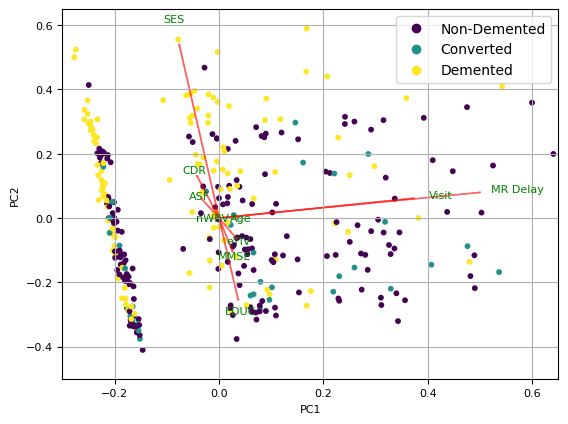

In [14]:
from sklearn.decomposition import PCA

X = df_preprocessed[pca_features]
y = df_preprocessed['Group']
   
pca = PCA()
x_new = pca.fit_transform(X)

def myplot(score,coeff, orig_feat=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    scatter = plt.scatter(xs * scalex,ys * scaley, c = y, s = 10)
    labels = np.unique(y)
    handles = [plt.Line2D([],[],marker="o", ls="", color=scatter.cmap(scatter.norm(yi))) for yi in labels]
    labels = ['Non-Demented', 'Converted', 'Demented']
    plt.legend(handles, labels)
    s = .63
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*s, coeff[i,1]*s,color = 'r',alpha = 0.5)
        if orig_feat is None:
            plt.text(coeff[i,0] * 1.15 * s, coeff[i,1] * 1.15 * s, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0] * 1.15 * s, coeff[i,1] * 1.15 * s, orig_feat[i], color = 'g', ha = 'center', va = 'center', fontsize=8)
    plt.xlim(-.3,.65)
    plt.ylim(-.5,.65)
    plt.xlabel("PC{}".format(1), fontsize=8)
    plt.ylabel("PC{}".format(2), fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid()

#Call the function. Use only the 2 PCs.
myplot(score=x_new[:,0:2],coeff=np.transpose(pca.components_[0:2, :]),orig_feat=pca_features)
plt.show()

In [15]:
"""
from pca import pca
import pandas as pd
from sklearn.datasets import load_iris


X = df_preprocessed[pca_features]
y = df_preprocessed['Group']

model = pca(n_components=.95)

# Fit and transform
results = model.fit_transform(X=X, row_labels=y)

# Plot the explained variance
fig, ax = model.plot()

# Scatter the first two PCs
fig, ax = model.scatter()

# Create a biplot
fig, ax = model.biplot(n_feat=4)
"""

"\nfrom pca import pca\nimport pandas as pd\nfrom sklearn.datasets import load_iris\n\n\nX = df_preprocessed[pca_features]\ny = df_preprocessed['Group']\n\nmodel = pca(n_components=.95)\n\n# Fit and transform\nresults = model.fit_transform(X=X, row_labels=y)\n\n# Plot the explained variance\nfig, ax = model.plot()\n\n# Scatter the first two PCs\nfig, ax = model.scatter()\n\n# Create a biplot\nfig, ax = model.biplot(n_feat=4)\n"

In [16]:
len(df_demographics_input[df_demographics_input['Group'] != 'Converted'])

336

### Processing image data.
This code is responsible for loading MRI "nifti.img" files from a specified directory, processing the data, and cleaning the data based on none values in the demographics.
It utilizes the `nibabel` library to load the MRI files and extract relevant information.

In [17]:
rootdir = '../OASIS2'


mri_patients_scans_name = []
mri_ignored_file_names = []
mri_images = []
mri_images_data = []

# Count the total number of files in the root directory
file_count = sum(len(files) for _, _, files in os.walk(rootdir))

print(f'Found {file_count} files in "{rootdir}" subdirectories\n')
print('Loading MRI "nifti.img" files:')

# Display a progress bar using tqdm
with tqdm(total=file_count) as pbar:
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            filepath = os.path.join(subdir, file)

            if filepath.endswith("nifti.img"):
                try:
                    # Load the MRI image using nibabel
                    img = nib.load(filepath)
                    mri_images.append(img)
                    mri_patients_scans_name.append(clearFilePath(filepath))
                    mri_images_data.append(img.get_fdata())
                except nib.filebasedimages.ImageFileError as e:
                    # If the file type is not recognized, ignore the file and print a message
                    mri_ignored_file_names.append(filepath)
                    print(
                        f'File type not recognized - ignoring "{filepath}" file')

            pbar.update(1)

print(
    f'\nFound and loaded {len(mri_patients_scans_name)} MRI "nifti.img" files from "{rootdir}" subdirectories')
print(f'Ignored:')
print(*mri_ignored_file_names, sep=' ')

# Get unique patient visit names from MRI file names
mri_patients_visits_names = np.unique(
    [re.sub('_\d\Z', '', i) for i in mri_patients_scans_name])

# Filter the demographics dataframe based on the MRI IDs
df_demographics = df_demographics_input[df_demographics_input['MRI ID'].isin(
    mri_patients_visits_names)]

print("Before cleaning data from none values from demographics:")
print(
    f'Number of patients visits: {len(np.unique(mri_patients_visits_names))}')
print(f'Number of patients scans: {len(mri_patients_scans_name)}')
print(
    f'Number of slices of MRI scans (unique values): {np.unique([arr.shape[2] for arr in mri_images_data])}')

# Drop rows in demographics dataframe with None values
df_drop = df_demographics[df_demographics.isna().any(axis=1)]
list_drop = df_drop['MRI ID'].tolist()
print(
    f'None value rows in demographics data to drop: {df_demographics.isnull().any(axis=1).sum()}')
df_demographics = df_demographics.dropna().reset_index(drop=True)

# Remove corresponding MRI files and names based on dropped rows
fname_drop = [fname for fname in mri_patients_scans_name if re.sub(
    '_\d\Z', '', fname) in list_drop]
fname_drop_id = [i for i in range(
    len(mri_patients_scans_name)) if mri_patients_scans_name[i] in fname_drop]

for i in reversed(fname_drop_id):
    del mri_images[i]
    del mri_patients_scans_name[i]
    del mri_images_data[i]

print(f"After cleaning data from none values from demographics:")
print(f"Number of removed MRI files: {len(fname_drop)}")
print(
    f"Number of patients visits: {len(np.unique(mri_patients_visits_names))}")
print(f"Number of patients scans: {len(mri_patients_scans_name)}")


Found 3376 files in "../OASIS2" subdirectories

Loading MRI "nifti.img" files:


100%|██████████████████████████████| 3376/3376 [05:04<00:00, 11.08it/s]



Found and loaded 1368 MRI "nifti.img" files from "../OASIS2" subdirectories
Ignored:

Before cleaning data from none values from demographics:
Number of patients visits: 374
Number of patients scans: 1368
Number of slices of MRI scans (unique values): [128]
None value rows in demographics data to drop: 19
After cleaning data from none values from demographics:
Number of removed MRI files: 71
Number of patients visits: 374
Number of patients scans: 1297


#### Visualizing MRI Data
This code segment performs visualizations of MRI slices using the matplotlib.pyplot library. It demonstrates the visualization of different slices from an MRI image.

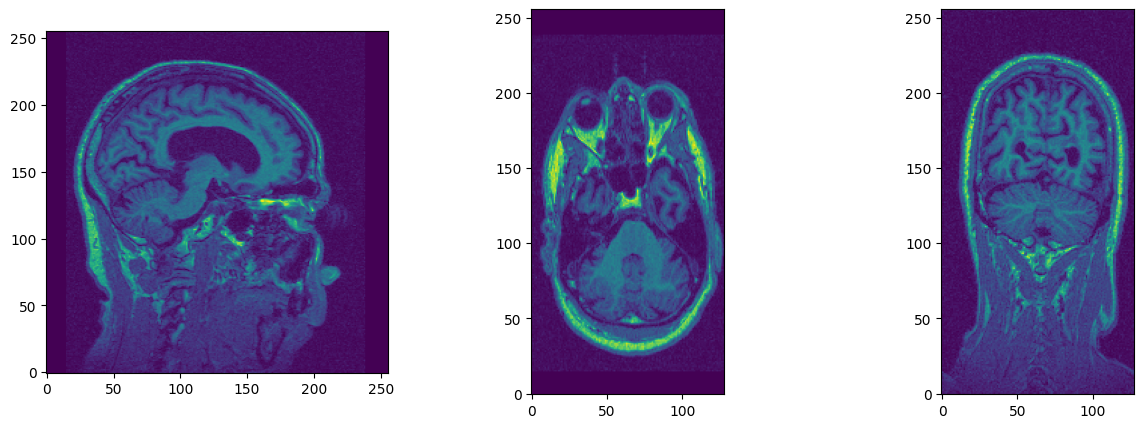

In [18]:
i = np.transpose(mri_images_data[0], (1, 0, 2, 3))
# Transpose the MRI image data to rearrange the dimensions for visualization

plt.figure(figsize=(15, 5))
# Create a figure with a size of 15x5 inches

plt.subplot(131)
# Define the first subplot in a 1x3 grid

plt.imshow(np.transpose(
    mri_images_data[0][:, :, 75], (1, 0, 2)), origin='lower')
# Display the transposed MRI image slice at index 75
# Adjust the dimensions for proper display using np.transpose()
# Set the origin of the image to the lower-left corner

plt.subplot(132)
# Define the second subplot in the grid

plt.imshow(i[120, :, :], origin='lower')
# Display a different slice of the transposed MRI image (at index 120)

plt.subplot(133)
# Define the third subplot in the grid

plt.imshow(i[:, 70, :], origin='lower')
# Display another slice of the transposed MRI image (at index 70)

plt.show()
# Show the figure with the three subplots and MRI slice visualizations


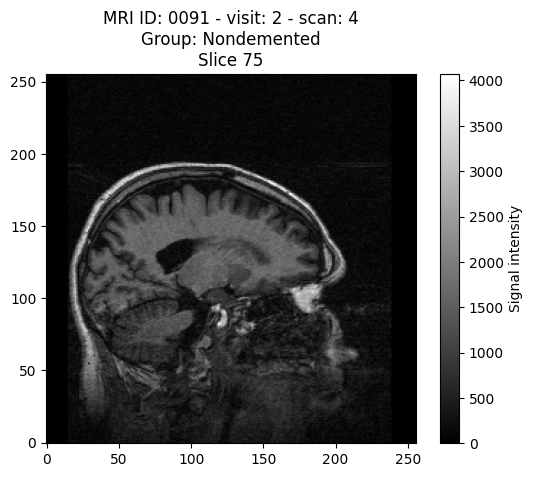

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
185,OAS2_0091,OAS2_0091_MR2,Nondemented,2,1047,M,R,78,12,4.0,29.0,0.0,1505.65,0.714846,1.16561


In [20]:
image, s = 40, 75
# Define the image and slice indices to visualize

img_data = mri_images_data[image]
# Retrieve the MRI image data for the specified image index

img_data = np.transpose(img_data, (1, 0, 2, 3))
# Transpose the MRI image data to rearrange the dimensions for visualization

mid_slice_x = img_data[:, :, s]
# Extract the slice at index 's' from the transposed MRI image data

mri_file_name = mri_patients_scans_name[image]
# Retrieve the MRI file name corresponding to the specified image index

patient_id = list(filter(None, re.split('_|MR', mri_file_name)))[1:]
# Extract the patient ID from the MRI file name using regex

patient_data = df_demographics[df_demographics['MRI ID'] == re.sub(
    '_\d\Z', '', mri_file_name)]
# Retrieve the demographics data for the patient ID obtained from the MRI file name

plt.title(f'MRI ID: {patient_id[0]} - visit: {patient_id[1]} - scan: {patient_id[2]}\nGroup: {patient_data.iloc[0][2]}\nSlice {s}')
# Set the title of the plot with relevant information, such as MRI ID, visit, scan, group, and slice index

plt.imshow(mid_slice_x, cmap='gray', origin='lower')
# Display the extracted MRI slice using a grayscale colormap and with the origin set to the lower-left corner

plt.colorbar(label='Signal intensity')
# Add a colorbar to the plot with the label 'Signal intensity'

plt.show()
# Show the plot with the MRI slice visualization

patient_data
# Display the demographics data for the corresponding patient ID


In [ ]:
mri_patients_scans_name[0]

In [ ]:
df = pd.DataFrame(columns=['id'] + df_preprocessed.columns.values.tolist())

for i in range(0, len(mri_patients_scans_name)):
    mri_file_name = mri_patients_scans_name[i]
    patient_data = df_preprocessed[df_preprocessed['MRI ID'] == re.sub('_\d\Z', '', mri_file_name)]
    df = pd.concat([df, patient_data], ignore_index=True)
    df.loc[i,'id']=mri_file_name
    #patient_data
df

In [ ]:
os.makedirs('../examples/data/oasis2', exist_ok=True)  
df.to_csv('../examples/data/oasis2/oasis2.csv')

In [ ]:
len(mri_patients_scans_name)

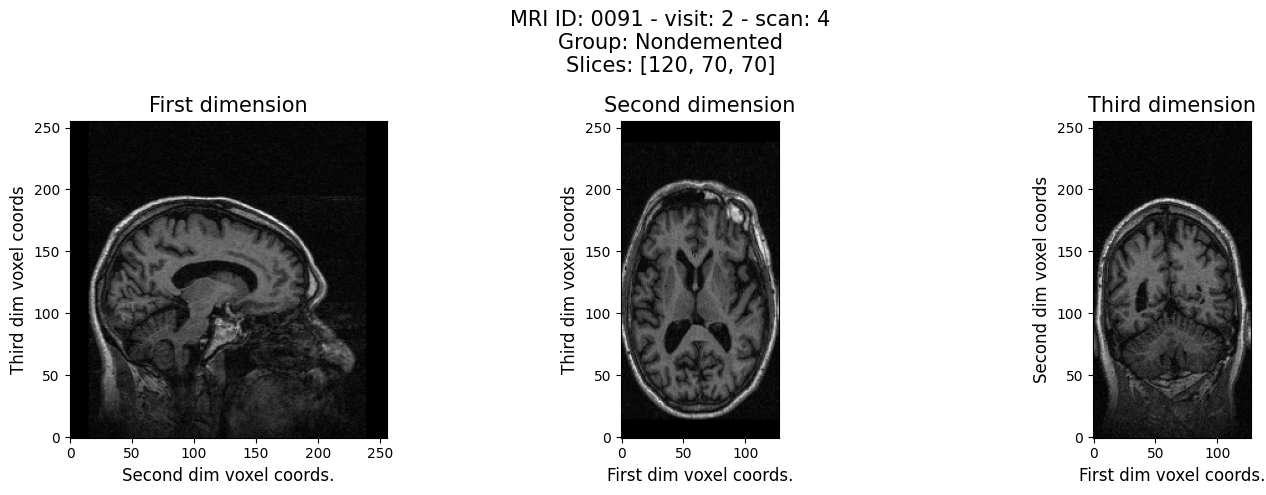

In [21]:
slice_no = [120, 70, 70]
# Define the slice numbers to visualize in each dimension

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
# Create a figure with three subplots arranged in a single row

ax[0].imshow(img_data[:, :, slice_no[2]], origin='lower', cmap='gray')
ax[0].set_xlabel('Second dim voxel coords.', fontsize=12)
ax[0].set_ylabel('Third dim voxel coords', fontsize=12)
ax[0].set_title('First dimension', fontsize=15)
# Display the slice along the first dimension in the first subplot
# Set the x-axis and y-axis labels
# Set the title for the subplot indicating the dimension

ax[1].imshow(img_data[slice_no[0], :, :], origin='lower', cmap='gray')
ax[1].set_xlabel('First dim voxel coords.', fontsize=12)
ax[1].set_ylabel('Third dim voxel coords', fontsize=12)
ax[1].set_title(f'Second dimension', fontsize=15)
# Display the slice along the second dimension in the second subplot
# Set the x-axis and y-axis labels
# Set the title for the subplot indicating the dimension

ax[2].imshow(img_data[:, slice_no[1], :], origin='lower', cmap='gray')
ax[2].set_xlabel('First dim voxel coords.', fontsize=12)
ax[2].set_ylabel('Second dim voxel coords', fontsize=12)
ax[2].set_title(f'Third dimension', fontsize=15)
# Display the slice along the third dimension in the third subplot
# Set the x-axis and y-axis labels
# Set the title for the subplot indicating the dimension

fig.suptitle(
    f'MRI ID: {patient_id[0]} - visit: {patient_id[1]} - scan: {patient_id[2]}\nGroup: {patient_data.iloc[0][2]}\nSlices: {slice_no}', fontsize=15)
# Set the super-title of the figure with relevant information, such as MRI ID, visit, scan, group, and the selected slice numbers

fig.tight_layout()
# Adjust the subplots layout to prevent overlapping


In [ ]:

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_demographics_input[df_demographics_input['Group']
                != 'Converted'], y='eTIV', x='Age', hue='Group')
plt.title("eTIV vs Age")


In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_demographics_input[df_demographics_input['Group']
                != 'Converted'], y='nWBV', x='Age', hue='Group')
plt.title("nWBV vs Age")


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_demographics_input['Group'])


In [ ]:
mri_images_data[0].shape


In [ ]:
# Retrieve the patient details from the demographics data
def get_patient_detail(index):
    mri_file_name = mri_patients_scans_name[index]
    patient_data = df_demographics_input[df_demographics_input['MRI ID'] == re.sub(
        '_\d\Z', '', mri_file_name)]
    return patient_data


### Data Preprocessing
Encoding categorical label data in data preprocessing. This code segment demonstrates the use of the LabelEncoder classes to encode categorical data. 

Also, we are selecting only three frame images from 3D image  dataset to reduce the computational time for the model training.Also VGG16 model is used for transfer learning and it only support only 3 channel images.


In [308]:
from tensorflow.keras.utils import to_categorical

cnn_y = []
# Initialize an empty list to store the labels for CNN classification

for i in range(len(mri_images_data)):
    # Iterate through each MRI image data

    # Retrieve the patient group information using the 'get_patient_detail' function
    patient_group = get_patient_detail(i)['Group'].values[0]

    # Append the patient group to the 'cnn_y' list
    cnn_y.append(patient_group)

# Initialize a label encoder object for encoding the patient groups

# Encode the patient groups using label encoding and convert them to number format
cnn_y = to_categorical(label_encoder.fit_transform(cnn_y))


IndexError: index 0 is out of bounds for axis 0 with size 0

In [22]:
# selects a subset of three consecutive slices (indexed 70, 100, and 125) from each MRI image in the mri_images_data array.
# It then reshapes the subset to have a consistent shape of (256, 256, 3) representing an RGB image.
# The resulting transformed data is stored in the mri_images_data_p numpy array for further processing or visualization.
mri_images_data_p = np.array(
    [i[:, :, [70, 100, 125]].reshape(256, 256, 3) for i in mri_images_data])


In [34]:
from PIL import Image

save_path = '../examples/data/oasis2/mri/img/'

os.makedirs(save_path, exist_ok=True)  

for i, img in enumerate(mri_images_data_p):
    #img = img.transpose(2, 0, 1)
    im = Image.fromarray((img * 255).astype(np.uint8), 'RGB')
    im.save(save_path + mri_patients_scans_name[i] + ".jpg")

In [36]:
im = Image.fromarray((mri_images_data_p[0][0] * 255).astype(np.uint8))
im.save('test.jpg')

In [35]:
print(f"{bold('Length if image data: ')}{len(mri_images_data)}")
print(f"{bold('Length of y: ')}{len(cnn_y)}")
print(f"{bold('shape of a image: ')}{mri_images_data_p[0].shape}")


Length if image data: 209

Length of y: 209

shape of a image: (256, 256, 3)


### DATA ANALYSIS

#### Importing pre-trained model

VGG16 is a popular convolution's neural network architecture widely used for various computer vision tasks, including image classification. ImageNet is a large-scale dataset with millions of labeled images used for training deep learning models.

In [42]:
from tensorflow.keras import applications
# VGG16 pre-trained model without fully connected layers and with different input dimensions
input_shape = (256, 256, 3)
model = applications.VGG16(
    weights="imagenet", include_top=False, input_shape=input_shape)
model.summary()


Model: "vgg16"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         

                                                                 

 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         

                                                                 

 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    

                                                                 

 block2_pool (MaxPooling2D)  (None, 64, 64, 1

In [43]:
# freeze the models layers
for layer in model.layers:
    layer.trainable = False


In [46]:
from tensorflow.keras.layers import LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model

# Flatten the output of the base model
flatten = Flatten()(model.output)

# Add a fully connected layer with 64 units
fc1 = Dense(64)(flatten)

# Apply LeakyReLU activation to introduce non-linearity
leaky_relu = LeakyReLU(alpha=0.1)(fc1)

# Add the final output layer with 3 units and softmax activation
output = Dense(3, activation='softmax')(leaky_relu)

# Create a new model by specifying the input and output layers
new_model = Model(inputs=model.input, outputs=output)

# Compile the new model with optimizer, loss function, and metrics
new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the new model
new_model.summary()


Model: "model_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         

                                                                 

 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      

                                                                 

 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     

                                                                 

 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         

                                                                 

 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     

                                                                 

 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    

                                                                 

 block2_pool (MaxPooling2D)  (None, 64, 64,

#### Splitting data into training and test

In [47]:
from sklearn.model_selection import train_test_split

#  split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(
    mri_images_data_p, cnn_y, test_size=.25)

print(f"{bold('Train shape: ')}{train_X.shape}")
print(f"{bold('Test shape: ')}{test_X.shape}")


Train shape: (156, 256, 256, 3)

Test shape: (53, 256, 256, 3)


#### Training the model

In [48]:
from tensorflow.keras.callbacks import EarlyStopping

# Define an early stopping callback with a patience of 6 epochs
early_stopping = EarlyStopping(patience=6)

# Train the new model with early stopping
hist = new_model.fit(train_X, train_y, validation_split=.2,
                     epochs=20, callbacks=[early_stopping])


Epoch 1/20

4/4 [==============================] - 19s 5s/step - loss: 756.2971 - accuracy: 0.3871 - val_loss: 203.5698 - val_accuracy: 0.5938

Epoch 2/20

4/4 [==============================] - 18s 5s/step - loss: 113.2766 - accuracy: 0.7419 - val_loss: 60.3831 - val_accuracy: 0.7812

Epoch 3/20

4/4 [==============================] - 19s 5s/step - loss: 17.9582 - accuracy: 0.9274 - val_loss: 47.1337 - val_accuracy: 0.7812

Epoch 4/20

4/4 [==============================] - 17s 5s/step - loss: 15.8794 - accuracy: 0.9194 - val_loss: 21.7707 - val_accuracy: 0.8750

Epoch 5/20

4/4 [==============================] - 22s 6s/step - loss: 4.4013 - accuracy: 0.9839 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

Epoch 6/20

4/4 [==============================] - 22s 6s/step - loss: 1.5987 - accuracy: 0.9919 - val_loss: 0.0997 - val_accuracy: 0.9688

Epoch 7/20

4/4 [==============================] - 26s 7s/step - loss: 2.1814 - accuracy: 0.9758 - val_loss: 0.0000e+00 - val_accuracy: 1.0000

E

#### Visualization of Accuracy and Validation loss of the model while training

<AxesSubplot: title={'center': 'Accuracy vs Validaion Accuracy'}>

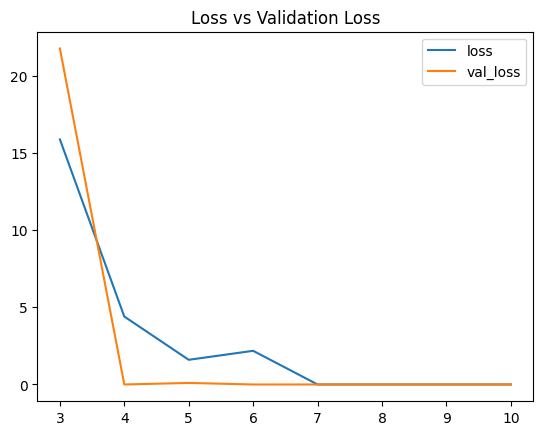

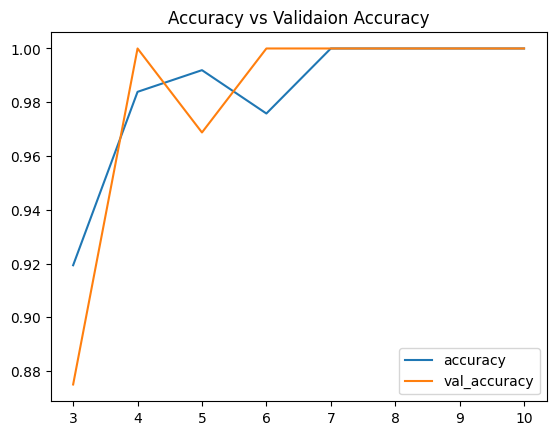

In [49]:
pd.DataFrame(hist.history).iloc[3:, [0, 2]].plot(
    title="Loss vs Validation Loss")
pd.DataFrame(hist.history).iloc[3:, [1, 3]].plot(
    title="Accuracy vs Validaion Accuracy")


#### Prediction

In [50]:
# predictions on x_test dataset
y_pred = np.argmax(new_model.predict(test_X), axis=1)


2/2 [==============================] - 5s 2s/step


### Metrics
- Accuracy Score
- F1 Score
- Confusion Matrix
- Classification Report

In [56]:

print(f"{bold('Accuracy Score: ')}{accuracy_score(np.argmax(test_y,axis=1),y_pred)}\n")
print(f"{bold('Classification report')}{classification_report(np.argmax(test_y,axis=1),y_pred)}\n")
print(f"{bold('F1 Score: ')}{f1_score(np.argmax(test_y,axis=1),y_pred, average=None)}\n")


Accuracy Score: 0.9433962264150944



Classification report              precision    recall  f1-score   support



           0       1.00      1.00      1.00         5

           1       1.00      0.86      0.92        21

           2       0.90      1.00      0.95        27



    accuracy                           0.94        53

   macro avg       0.97      0.95      0.96        53

weighted avg       0.95      0.94      0.94        53





F1 Score: [1.         0.92307692 0.94736842]




Text(0.5, 1.0, 'Confusion Matrix')

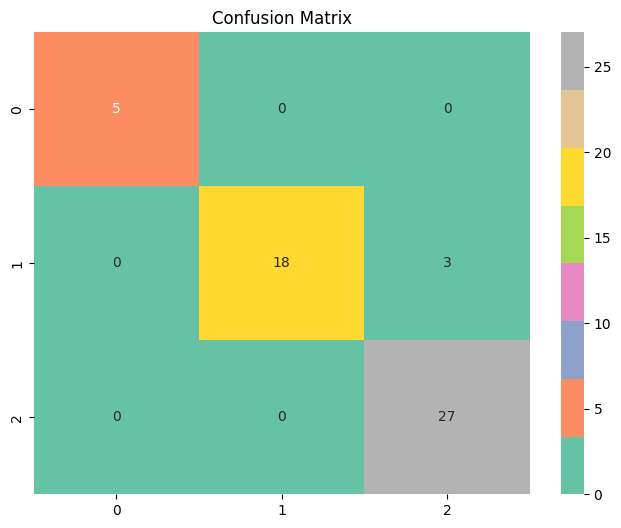

In [61]:
# CONFUSION MATRIX PLOT
plt.figure(figsize=(8, 6))

# Compute the confusion matrix
c_m = confusion_matrix(np.argmax(test_y, axis=1), y_pred)

# Plot the confusion matrix as a heatmap
sns.heatmap(c_m, annot=True,cmap='Set2')
plt.title("Confusion Matrix")

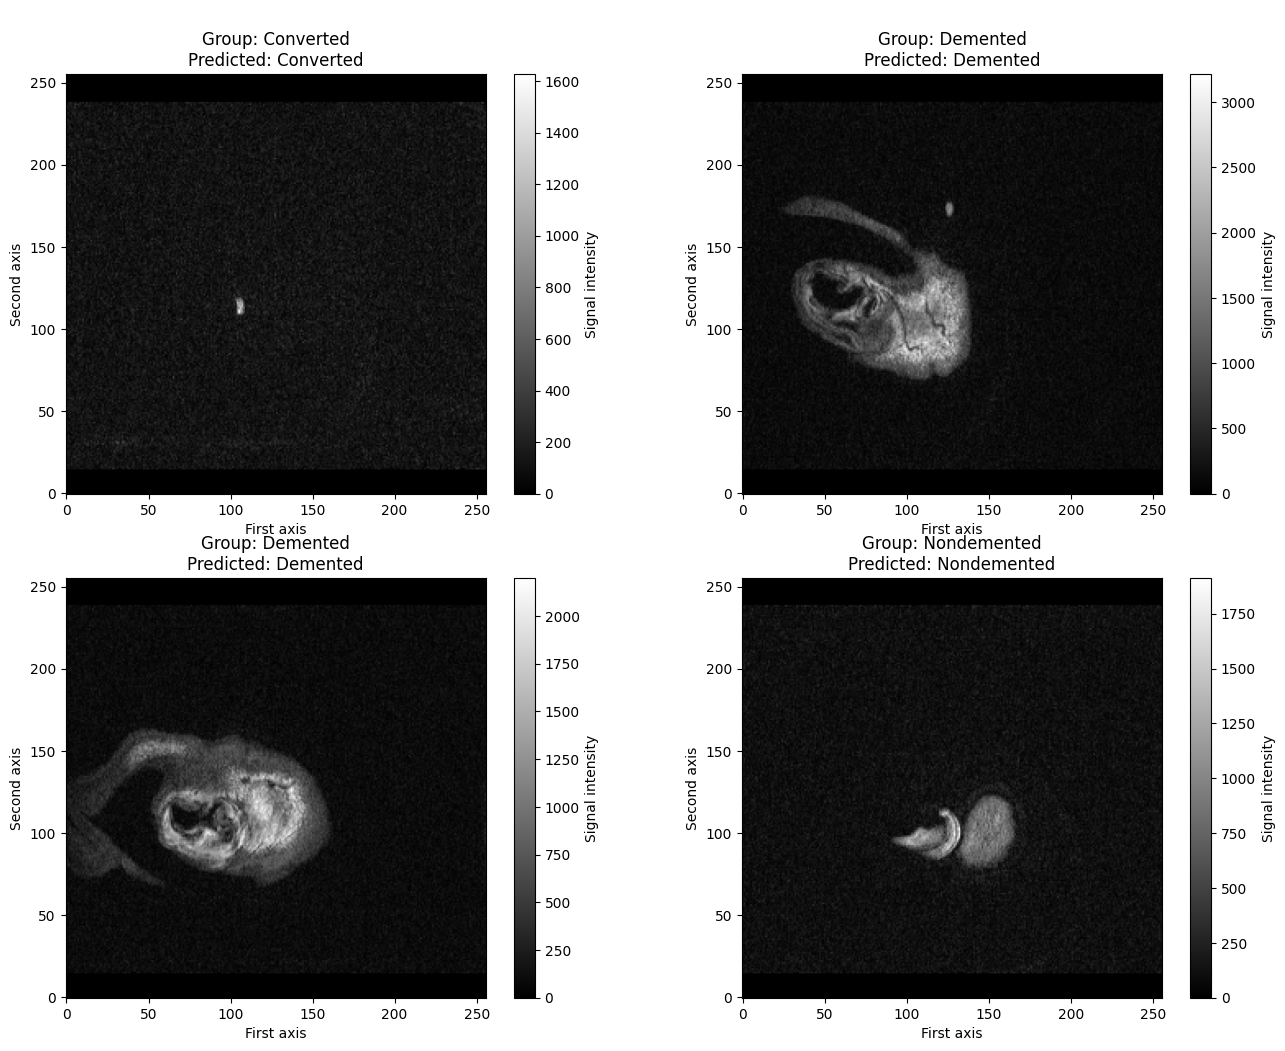

In [63]:
# Plot the 4 images from the test dataset after prediction with its actual and predicted labels

images = [6, 10, 14, 26]
plt.figure(figsize=(16, 12))

for index, image in enumerate(images):
    img_data = test_X[image]

    mri_file_name = mri_patients_scans_name[image]
    true = label_encoder.classes_[np.argmax(test_y, axis=1)[image]]
    actual = label_encoder.classes_[y_pred[image]]

    plt.subplot(2, 2, index+1)
    plt.title(f'\nGroup: {true}\nPredicted: {actual}')
    plt.imshow(img_data[:, :, -1], cmap='gray', origin='lower')
    plt.xlabel('First axis')
    plt.ylabel('Second axis')
    plt.colorbar(label='Signal intensity')
plt.show()


### Post Analysis 
Saving the model weights 

In [64]:
new_model.save("OASIS_MODEL_1.h5")

### Results 
The data set has MRI images of `3-dimensional black-and-white images with shape (256, 256, 128)`. But, the pre-trained model used has been trained on images of `shape (224,224,3)`. Hence the data set was transformed into a shape in the format required for the model, and `specific frames (i.e., 75th, 100th and 125th)` were selected. The labels/target column (i.e., demented, non-demented and converted) were extracted from each `subject's Demographic (DM) data` for the respective images. These labels, along with the MRI images, were combined and used for training the model.  

### Discussion 

`Convolution Neural Network(CNN)` is a popular algorithm for `image recognition` because it can detect patterns and objects in the image. We specifically decided to move ahead with VGG16, a pre-trained CNN model, as we had limited data sources, which would not have been enough to train a CNN from scratch due to its complex structure. 

 

Further, it's very interesting to note that in the `OASIS2 brain dataset`, we have 72 subjects who identified as nondemented throughout the study, 64 subjects as demented in the initial visit and throughout the study, which also includes 51 subjects with mild to moderate Alzheimer's. The remaining 14 subjects were determined as non-demented in the initial visit and marked as demented in the later visits (converted). `These 14 subjects (converted) data is crucial for the problem statement, i.e., early detection, as their MRI samples tend to have patterns of the disease that looks like or develops in the early stages.`
#### Evaluation 

    The model tends to classify the images as `demented, non-demented and converted with an accuracy of 94 percent`. Still, accuracy alone cannot give us the whole picture as accuracy metrics only considers the correctly predicted(True Positive + True Negative) output with respect to total outputs. Hence, it can give a false perception in case of unbalanced data. 

     

    To overcome the limitation of accuracy score and as a requirement for the defined problem statement, we want to emphasize on reducing False Negative results, i.e. where a subject suffers from Alzheimer's, but the model detects otherwise. Therefore, the metrics we will focus on to evaluate the model are `Recall and F1 Score`. Recall, the fraction of the items of interest to the user retrieved by the system \cite{alvarez2002exact}. The harmonic mean of precision and recall, F1 score, is widely used to measure the success of a classifier when one class is rare \cite{lipton2014thresholding}. 

    `The Recall and F1 score for the given model is 95 percent and 92 percent, respectively. `  

 

#### Limitation 

 

The OASIS2 brain dataset consists of only 150 subjects and 373 MR sessions, all the subjects are aged between 60 and 96, and all the subjects are right-handed. We can see bias in the data as we do not have samples from young and left-handed subjects. 

 

Moreover, due to the data's complexity and large size(3d images), we could only train the model on limited subjects, as training the model on the whole data set would require greater computational power. 

 

  

 

#### Future Scope 

 

The future scope of the study would be to work with the latest `OASIS4 dataset`, which has more than `600 subjects and MR sessions`. But then, to process extensive data, we require robust systems that can process and transform the data. Further, we would like to collaborate with subject matter experts as they can assist us better in decision-making and understanding the problem. 

 

### Conclusions 

In conclusion, the `study focuses on Alzheimer's disease detection at an early stage using image recognition with CNN.` This study can be used in the development of robust diagnostics tools. Additionally, it can further improve Alzheimer's disease detection and highlights the potential of machine learning and neuroimaging techniques in the advanced understanding of structural change in the brain.  

### References
- Data were provided by OASIS [Longitudinal: Principal Investigators: D. Marcus, R, Buckner, J. Csernansky, J. Morris; P50 AG05681, P01 AG03991, P01 AG026276, R01 AG021910, P20 MH071616, U24 RR021382](https://doi.org/10.1162/jocn.2009.21407)
- Philip Scheltens, Ka j Blennow, Monique M B Breteler, Bart de Strooper, Giovanni B Frisoni, Stephen Salloway, and Wiesje Maria Van der Flier. Alzheimer’s disease. The Lancet, 388(10043):505–517, 2016.
- Karteek Popuri, Da Ma, Lei Wang, and Mirza Faisal Beg. Using machine learn- ing to quantify structural mri neurodegen- eration patterns of alzheimer’s disease into dementia score: Independent validation on 8,834 images from adni, aibl, oasis, and miriad databases. Human Brain Mapping, 41(14):4127–4147, 2020.
- Daniel S. Marcus, Anthony F. Fotenos, John G. Csernansky, John C. Morris, and Randy L. Buckner. Open Access Se- ries of Imaging Studies: Longitudinal MRI Data in Nondemented and Demented Older Adults. Journal of Cognitive Neuroscience, 22(12):2677–2684, 12 2010.
- Sergio A Alvarez. An exact analytical re- lation among recall, precision, and classi- fication accuracy in information retrieval. Boston College, Boston, Technical Report BCCS-02-01, pages 1–22, 2002.
- Zachary Chase Lipton, Charles Elkan, and Balakrishnan Narayanaswamy. Threshold- ing classifiers to maximize f1 score. arXiv preprint arXiv:1402.1892, 2014.